<a href="https://colab.research.google.com/github/duongvotran/Water-Hackathon-2021/blob/main/DQO_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing dependencies and dataset

In [77]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.image as mpimg 

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [33]:
file = 'Water_data.xlsx'
sheet = 'DQO' # change excel sheet
data = pd.read_excel(file, sheet)

timestamp = data.columns[0]
quality_aspect = data.columns[1] # change examining quality aspect of wastewater
quality = data.filter(items = [timestamp, quality_aspect])
quality.head()

,Date,DQO-E (COD mg/L)
0,1990-01-01,344.0
1,1990-01-02,470.0
2,1990-01-03,518.0
3,1990-01-04,460.0
4,1990-01-07,466.0


#Indexing the time series data

In [34]:
quality = quality.set_index(timestamp)
quality.index

DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-07', '1990-01-08', '1990-01-09', '1990-01-10',
               '1990-01-11', '1990-01-12',
               ...
               '1991-08-20', '1991-08-21', '1991-08-22', '1991-08-23',
               '1991-08-25', '1991-08-26', '1991-08-27', '1991-08-28',
               '1991-08-29', '1991-08-30'],
              dtype='datetime64[ns]', name='Date', length=502, freq=None)

In [35]:
train_start = '1990'
resample = '3D' # change the resample rule
y = quality[quality_aspect].resample(resample).mean()
y

Date
1990-01-01    444.000000
1990-01-04    460.000000
1990-01-07    534.000000
1990-01-10    478.333333
1990-01-13    478.500000
                 ...    
1991-08-18    284.666667
1991-08-21    282.000000
1991-08-24    418.500000
1991-08-27    419.333333
1991-08-30    300.000000
Freq: 3D, Name: DQO-E (COD mg/L), Length: 203, dtype: float64

# Visualizing

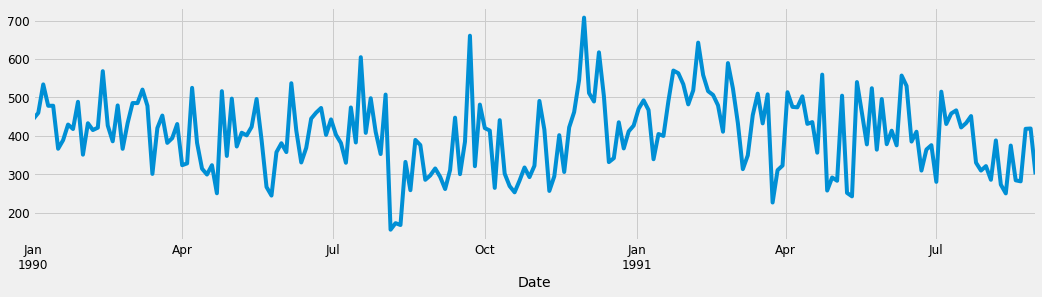

In [36]:
y.plot(figsize=(16, 4))
plt.show()

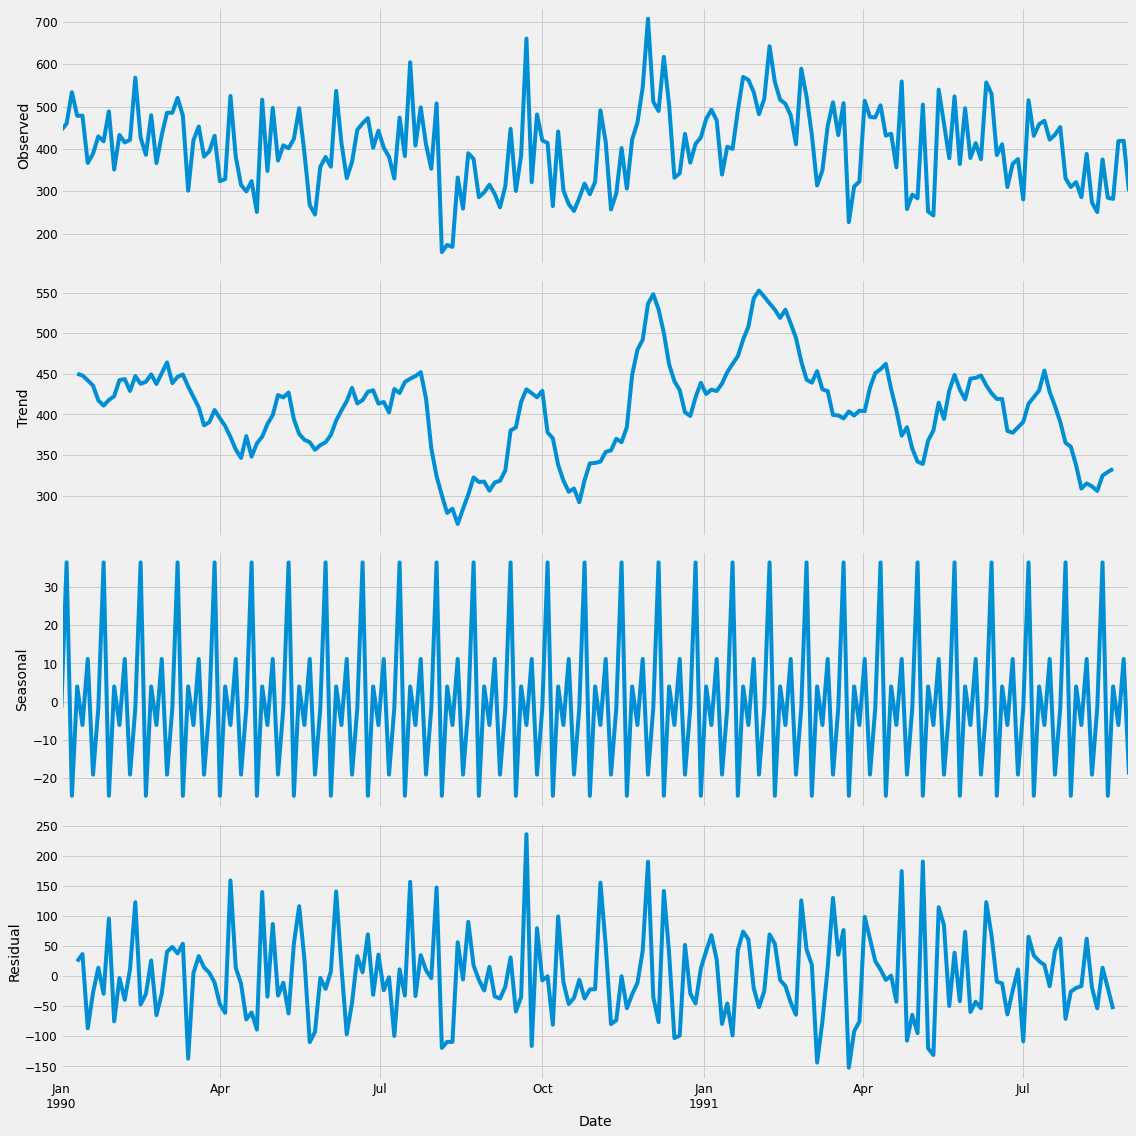

In [80]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 16

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()
fig.savefig("time-series-components.png")


# Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [38]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
period = 13
seasonal_pdq = [(x[0], x[1], x[2], period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 13)
SARIMAX: (0, 0, 1) x (0, 1, 0, 13)
SARIMAX: (0, 1, 0) x (0, 1, 1, 13)
SARIMAX: (0, 1, 0) x (1, 0, 0, 13)


This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [39]:
optimal_result = 10**6
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{}{} - AIC:{}'.format(param, param_seasonal, period, results.aic))
            
            if results.aic < optimal_result:
              optimal_result = results.aic
              optimal_order = param
              optimal_seasonal_order = param_seasonal
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 13)13 - AIC:3013.1266820490946
ARIMA(0, 0, 0)x(0, 0, 1, 13)13 - AIC:2680.3504475028585
ARIMA(0, 0, 0)x(0, 1, 0, 13)13 - AIC:2403.483023160765
ARIMA(0, 0, 0)x(0, 1, 1, 13)13 - AIC:2151.28875182021
ARIMA(0, 0, 0)x(1, 0, 0, 13)13 - AIC:2408.380307217914
ARIMA(0, 0, 0)x(1, 0, 1, 13)13 - AIC:2308.961677687571
ARIMA(0, 0, 0)x(1, 1, 0, 13)13 - AIC:2196.394087613544
ARIMA(0, 0, 0)x(1, 1, 1, 13)13 - AIC:2152.525202787712
ARIMA(0, 0, 1)x(0, 0, 0, 13)13 - AIC:2812.1862475069456
ARIMA(0, 0, 1)x(0, 0, 1, 13)13 - AIC:2557.888543406055
ARIMA(0, 0, 1)x(0, 1, 0, 13)13 - AIC:2380.286893020019
ARIMA(0, 0, 1)x(0, 1, 1, 13)13 - AIC:2118.696535296332
ARIMA(0, 0, 1)x(1, 0, 0, 13)13 - AIC:2395.533221018034
ARIMA(0, 0, 1)x(1, 0, 1, 13)13 - AIC:2277.184278968352
ARIMA(0, 0, 1)x(1, 1, 0, 13)13 - AIC:2175.0547845089936
ARIMA(0, 0, 1)x(1, 1, 1, 13)13 - AIC:2118.6741235949453
ARIMA(0, 1, 0)x(0, 0, 0, 13)13 - AIC:2460.690553477104
ARIMA(0, 1, 0)x(0, 0, 1, 13)13 - AIC:2309.2932705289772
ARIMA

In [40]:
print('ARIMA{}x{}{} - AIC:{}'.format(optimal_order, optimal_seasonal_order, period, optimal_result))

ARIMA(1, 1, 1)x(1, 1, 1, 13)13 - AIC:2098.8659132548596


# Fitting the ARIMA model

In [41]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order = optimal_order,
                                seasonal_order = optimal_seasonal_order,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2971      0.099      3.004      0.003       0.103       0.491
ma.L1         -0.8944      0.046    -19.463      0.000      -0.984      -0.804
ar.S.L13      -0.1813      0.098     -1.844      0.065      -0.374       0.011
ma.S.L13      -0.8938      0.101     -8.868      0.000      -1.091      -0.696
sigma2      8695.6190    895.374      9.712      0.000    6940.718    1.05e+04


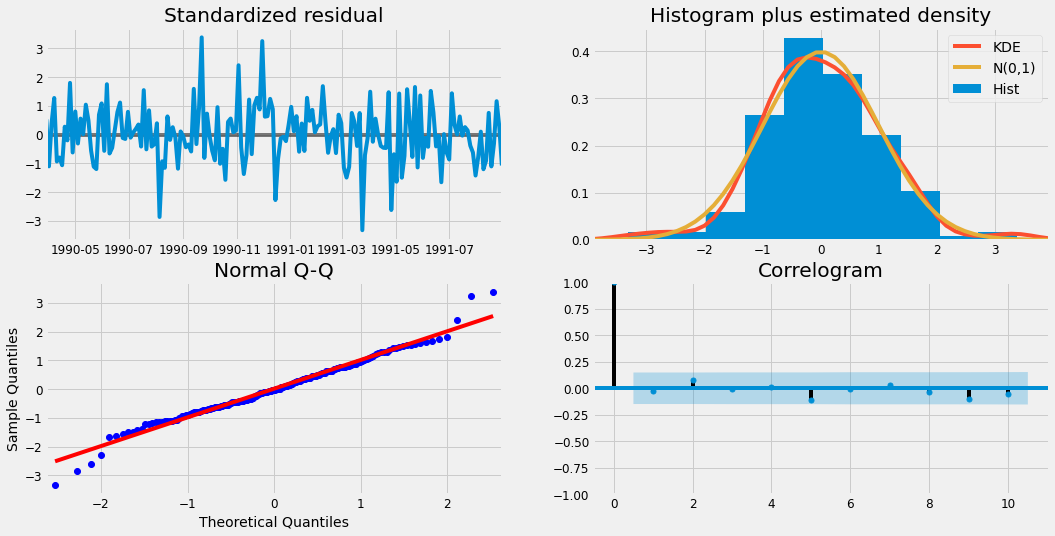

In [42]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating forecasts

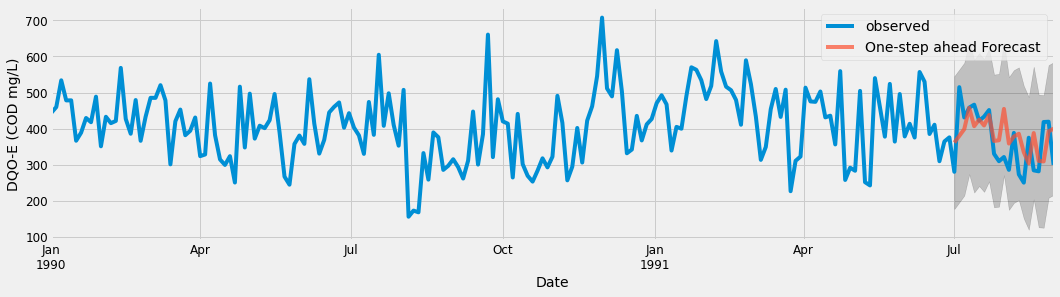

In [82]:
test_start = '1991-07-01' # change the start of test data
pred = results.get_prediction(start=pd.to_datetime(test_start), dynamic=False)
pred_ci = pred.conf_int()

fig=plt.figure()
ax = y[train_start:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel(timestamp)
ax.set_ylabel(quality_aspect)
plt.legend()

plt.show()
fig.savefig("validating-forecast.png")

In [50]:
y_forecasted = pred.predicted_mean
y_truth = y[test_start:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5565.91


In [51]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 74.61


#Producing and visualizing forecasts

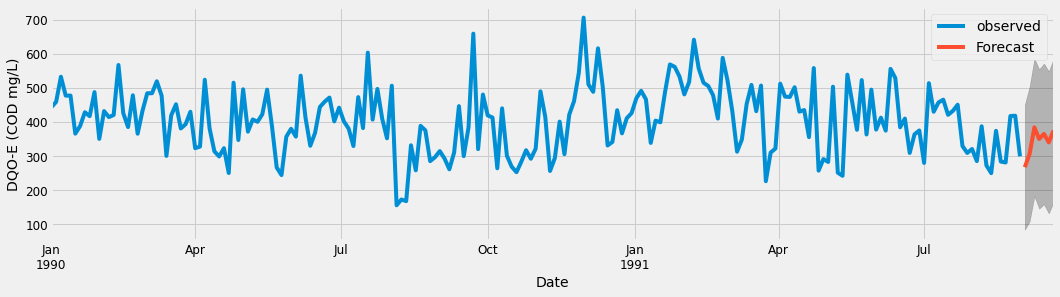

In [83]:
pred_uc = results.get_forecast(steps=7) # change the amount of predicted data
pred_ci = pred_uc.conf_int()

fig = plt.figure()
ax = y.plot(label='observed', figsize=(16, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel(timestamp)
ax.set_ylabel(quality_aspect)

plt.legend()
plt.show()
fig.savefig("future-forecasting.png")

In [73]:
pred_val = pd.DataFrame(pred_uc.predicted_mean, columns=[quality_aspect])
pred_val

,DQO-E (COD mg/L)
1991-09-02,268.137181
1991-09-05,306.993179
1991-09-08,385.234149
1991-09-11,351.055924
1991-09-14,366.018924
1991-09-17,341.003003
1991-09-20,376.071275


In [75]:
predict_result = [pred_val,pred_ci]
predict_result = pd.concat(predict_result, axis=1)
predict_result.to_excel("DQO-E prediction.xlsx")
predict_result

,DQO-E (COD mg/L),lower DQO-E (COD mg/L),upper DQO-E (COD mg/L)
1991-09-02,268.137181,84.596313,451.678049
1991-09-05,306.993179,109.107167,504.879191
1991-09-08,385.234149,183.065261,587.403037
1991-09-11,351.055924,146.414470,555.697378
1991-09-14,366.018924,159.358745,572.679103
1991-09-17,341.003003,132.483897,549.522110
1991-09-20,376.071275,165.754327,586.388224
